# Spherical Interpolation


In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate
!pip3 install labml
!pip3 install labml-nn
!pip3 install pytorch-lightning
!pip install Pillow==9.0.0

In [ ]:
# clone the repository
!git clone https://github.com/kk-digital/kcg-ml-sd1p4.git
# move to the repo
%cd kcg-ml-sd1p4/

In [ ]:
# download model weights
!wget https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt

In [12]:
"""
---
title: Generate images using stable diffusion with a prompt
summary: >
 Generate images using stable diffusion with a prompt
---

# Generate images using [stable diffusion](../index.html) with a prompt
"""

import os
from pathlib import Path

import torch

from labml import lab, monit
from stable_diffusion.latent_diffusion import LatentDiffusion
from stable_diffusion.sampler.ddim import DDIMSampler
from stable_diffusion.sampler.ddpm import DDPMSampler
from stable_diffusion.util import load_model, save_images, set_seed


class Txt2Img:
    """
    ### Text to image class
    """
    model: LatentDiffusion

    def __init__(self, *,
                 checkpoint_path: Path,
                 sampler_name: str,
                 n_steps: int = 50,
                 ddim_eta: float = 0.0,
                 ):
        """
        :param checkpoint_path: is the path of the checkpoint
        :param sampler_name: is the name of the [sampler](../sampler/index.html)
        :param n_steps: is the number of sampling steps
        :param ddim_eta: is the [DDIM sampling](../sampler/ddim.html) $\eta$ constant
        """
        # Load [latent diffusion model](../latent_diffusion.html)
        self.model = load_model(checkpoint_path)
        # Get device
        self.device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        # Move the model to device
        self.model.to(self.device)

        # Initialize [sampler](../sampler/index.html)
        if sampler_name == 'ddim':
            self.sampler = DDIMSampler(self.model,
                                       n_steps=n_steps,
                                       ddim_eta=ddim_eta)
        elif sampler_name == 'ddpm':
            self.sampler = DDPMSampler(self.model)

    @torch.no_grad()
    def __call__(self, *,
                 dest_path: str,
                 batch_size: int = 3,
                 prompt: str,
                 h: int = 512, w: int = 512,
                 uncond_scale: float = 7.5,
                 ):
        """
        :param dest_path: is the path to store the generated images
        :param batch_size: is the number of images to generate in a batch
        :param prompt: is the prompt to generate images with
        :param h: is the height of the image
        :param w: is the width of the image
        :param uncond_scale: is the unconditional guidance scale $s$. This is used for
            $\epsilon_\theta(x_t, c) = s\epsilon_\text{cond}(x_t, c) + (s - 1)\epsilon_\text{cond}(x_t, c_u)$
        """
        # Number of channels in the image
        c = 4
        # Image to latent space resolution reduction
        f = 8

        # Make a batch of prompts
        prompts = batch_size * [prompt]

        # AMP auto casting
        with torch.cuda.amp.autocast():
            # In unconditional scaling is not $1$ get the embeddings for empty prompts (no conditioning).
            if uncond_scale != 1.0:
                un_cond = self.model.get_text_conditioning(batch_size * [""])
            else:
                un_cond = None
            # Get the prompt embeddings
            cond = self.model.get_text_conditioning(prompts)
            # [Sample in the latent space](../sampler/index.html).
            # `x` will be of shape `[batch_size, c, h / f, w / f]`
            x = self.sampler.sample(cond=cond,
                                    shape=[batch_size, c, h // f, w // f],
                                    uncond_scale=uncond_scale,
                                    uncond_cond=un_cond)
            # Decode the image from the [autoencoder](../model/autoencoder.html)
            images = self.model.autoencoder_decode(x)

        # Save images
        save_images(images, dest_path, 'txt_')

    # functions for pipeline
    @torch.no_grad()
    def generate_text_embeddings(self, prompt, batch_size=4, uncond_scale=7.5):
        """
        :param prompt: is the prompt to generate images with
        """
        # Make a batch of prompts
        prompts = batch_size * [prompt]

        # AMP auto casting
        with torch.cuda.amp.autocast():
            # In unconditional scaling is not $1$ get the embeddings for empty prompts (no conditioning).
            if uncond_scale != 1.0:
                un_cond = self.model.get_text_conditioning(batch_size * [""])
            else:
                un_cond = None
            # Get the prompt embeddings
            cond = self.model.get_text_conditioning(prompts)
        
        # return the embeddings
        return cond, un_cond
    
    @torch.no_grad()
    def generate_latent_space(self, cond, un_cond, batch_size=4, uncond_scale=7.5, h=512, w=512):
        """
        :param prompt: is the prompt to generate images with
        """
        # Number of channels in the image
        c = 4
        # Image to latent space resolution reduction
        f = 8

        # AMP auto casting
        with torch.cuda.amp.autocast():
            # [Sample in the latent space](../sampler/index.html).
            # `x` will be of shape `[batch_size, c, h / f, w / f]`
            x = self.sampler.sample(cond=cond,
                                    shape=[batch_size, c, h // f, w // f],
                                    uncond_scale=uncond_scale,
                                    uncond_cond=un_cond)
        
        # return the embeddings
        return x
    
    @torch.no_grad()
    def generate_image(self, x):
        """
        :param prompt: is the prompt to generate images with
        """
        # AMP auto casting
        with torch.cuda.amp.autocast():
            # Decode the image from the [autoencoder](../model/autoencoder.html)
            image = self.model.autoencoder_decode(x)
        
        # return the embeddings
        return image


In [ ]:
# create an instance of the class
sampler_name = 'ddim'
steps = 50
batch_size = 4
scale = 7.5
uncond_scale = 7.5
txt2img = Txt2Img(checkpoint_path='sd-v1-4.ckpt',
                      sampler_name=sampler_name,
                      n_steps=steps)

In [7]:
prompt1 = "a photograph of an astronaut riding harley davidson"
prompt2 = "a photograph of an astronaut surfing"


# Get the embeddings for both prompts
embeddings1 = txt2img.generate_text_embeddings(prompt=prompt1, batch_size=batch_size, uncond_scale=uncond_scale)
embeddings2 = txt2img.generate_text_embeddings(prompt=prompt2, batch_size=batch_size, uncond_scale=uncond_scale)


In [17]:
#Get the latents fro the both prompts

latent_space1 = txt2img.generate_latent_space(cond=embeddings1[0], un_cond=embeddings1[1], batch_size=batch_size, uncond_scale=uncond_scale, h=512, w=512)
latent_space2 = txt2img.generate_latent_space(cond=embeddings2[0], un_cond=embeddings2[1], batch_size=batch_size, uncond_scale=uncond_scale, h=512, w=512)




#  InterpolateLatentSpherical


In [20]:
def interpolate_latent_spherical(latent1, latent2, alpha):
    latent1_flat, latent2_flat = latent1.view(latent1.shape[0], -1), latent2.view(latent2.shape[0], -1)
    latent1_norm, latent2_norm = torch.norm(latent1_flat, dim=-1), torch.norm(latent2_flat, dim=-1)
    dot_product = torch.sum(latent1_flat * latent2_flat, dim=-1) / (latent1_norm * latent2_norm)
    
    omega, sin_omega = torch.acos(dot_product), torch.sin(torch.acos(dot_product))
    alpha_weights, one_minus_alpha_weights = torch.sin(alpha * omega) / sin_omega, torch.sin((1 - alpha) * omega) / sin_omega
    
    return latent1 * one_minus_alpha_weights[:, None, None, None] + latent2 * alpha_weights[:, None, None, None]




In [21]:
def display_image(img_path):
    img = Image.open(img_path)
    display(img)


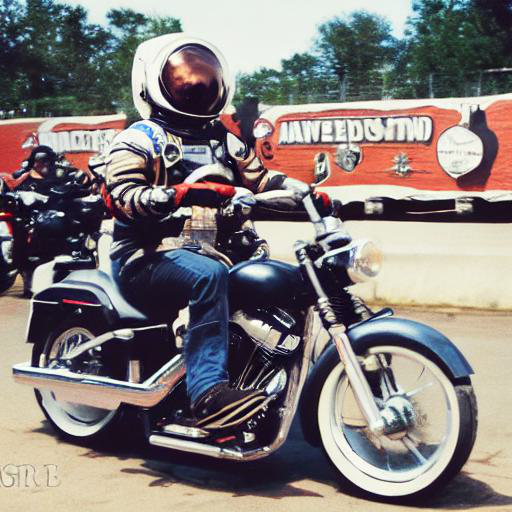

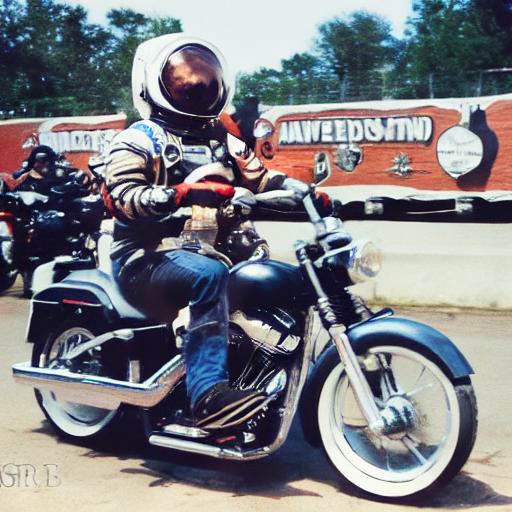

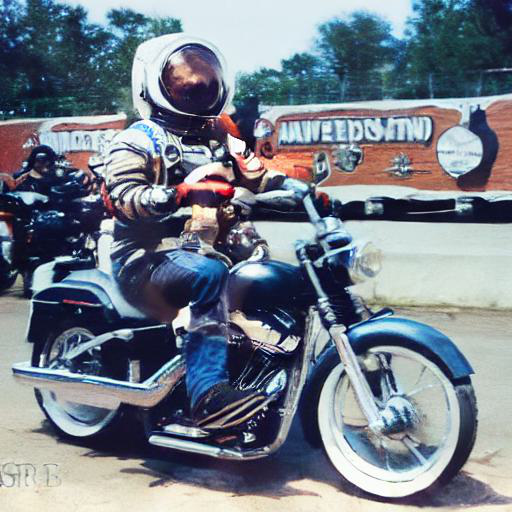

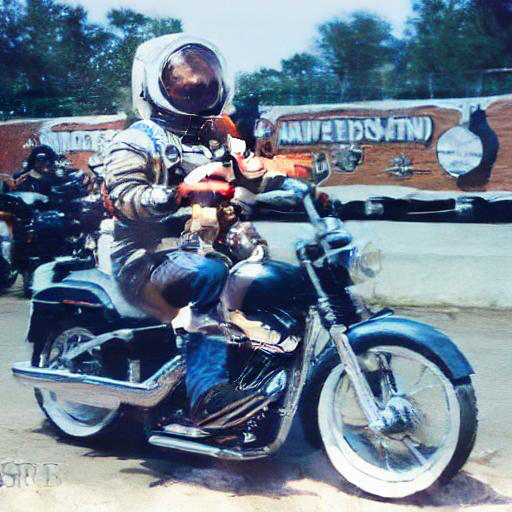

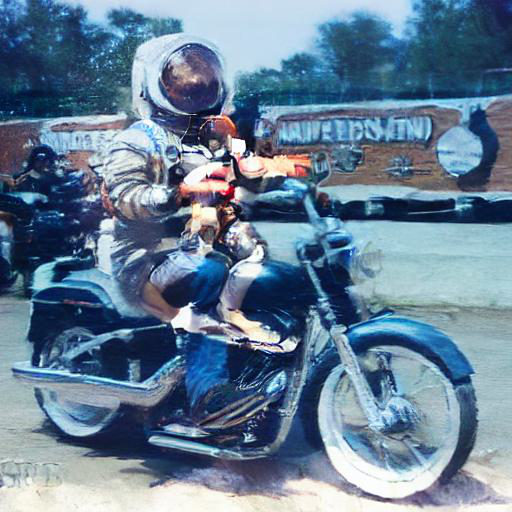

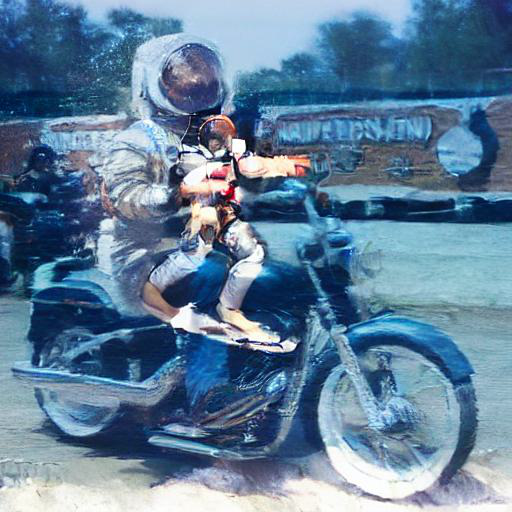

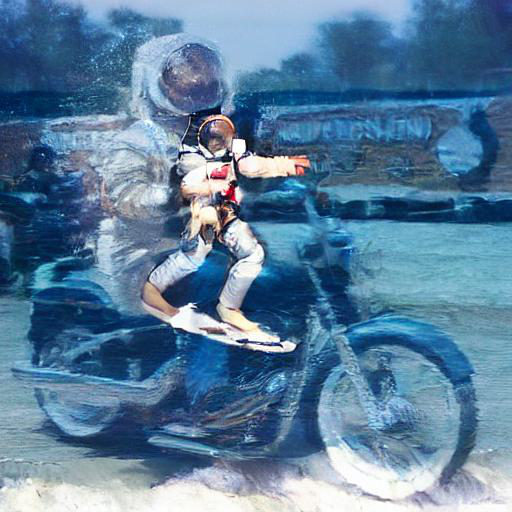

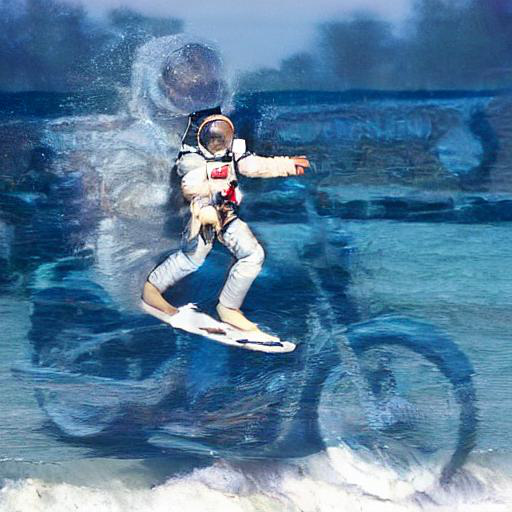

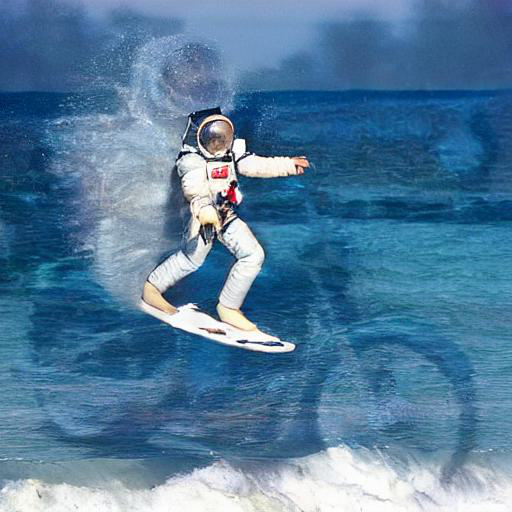

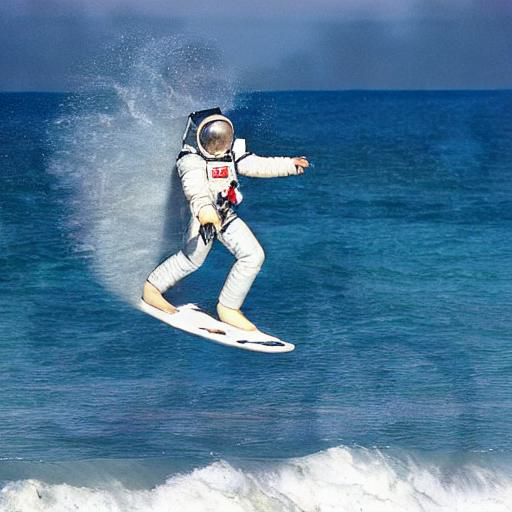

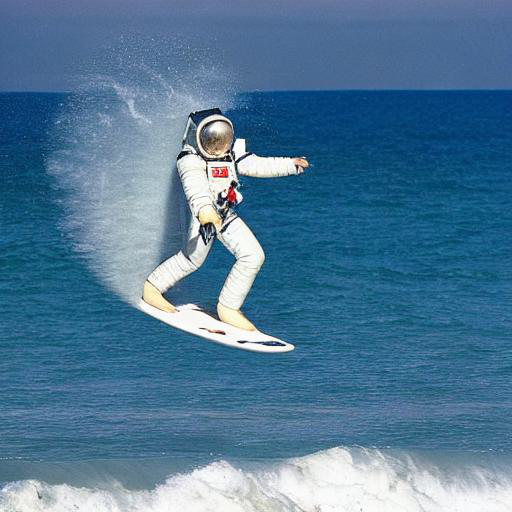

In [22]:
from PIL import Image

num_interpolations = 2
alphas = torch.tensor([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]).to(txt2img.device)
for i, alpha in enumerate(alphas):
    interpolated_latent_spherical = interpolate_latent_spherical(latent_space1, latent_space2, alpha)
        
    # Generate images from the interpolated latent
    with torch.no_grad():
        images = txt2img.model.autoencoder_decode(interpolated_latent_spherical)
        save_images(images, '/kaggle/working/output', f'interpolated_{i}')

    # Display the first and last images
    img_path = f"/kaggle/working/output/interpolated_{i}00000.jpeg"
    display_image(img_path)